In [1]:
# let's write pytorch-ify the code we have so far, train a deeper network, and visualize the gradients. we can
# collect metrics after doing a shallow train on the network to see how the initial gradients behave.

# some things to play around with and observe:
#   - without batch norm, the network will be sensitive to initial conditions.
#     - gradients will become unstable as they propagate deeper and deeper into the network.
#     - we will observe this if we play around with initial weights of the linear layers (i.e. tweaking the
#       weight initialization, tweaking the gain factor, etc.)
#   - with batch norm, the network will be resilient to initial conditions.
#     - if we choose imprecise initial values or even "actively bad" (extreme) initial values, the network's
#       gradients will be unaffected and look the same regardless.
#       - intuitively, this is because batch norm "disregards" the distribution of gradients that the initial
#         weights produce and "substitutes" its own (by reshaping ).
#     - the only change we'll see is in the "update step to data ratio". depending on the weight initialization
#       we choose, this ratio will change, either becoming bigger or smaller.
#       - if the update step becomes small compared to the data, we'll need to increase the learning rate.
#       - if the update step becomes big compared to the data, we'll need to decrease the learning rate.

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
torch.set_default_device("mps")

In [2]:
# we need to include some stuff from before.
g = torch.Generator(device='mps').manual_seed(2147483647) # for reproducibility
# read in all the words
words = open('res/names.txt', 'r').read().splitlines()
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)

In [3]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
  X, Y = [], []

  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

In [4]:
# define layer types in pytorch-like way
class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) #/ fan_in**0.5  # (try changing weight normalization)
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

In [5]:
# build a deeper network
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP

C = torch.randn((vocab_size, n_embd), generator=g)
# with batch norm (more resilient to initial conditions)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# # without batch norm (brittle to initial conditions)
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # (try changing adjustment on hidden layer weights)
  layers[-1].gamma *= 0.1  # with batch norm
  # layers[-1].weight *= 0.1  # without batch norm
  # (try changing gain on linear layer weights)
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 20 #1  # with batch norm
      # layer.weight *= 5/3  # without batch norm

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [6]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.3189


layer 2 (      Tanh): mean +0.00, std 0.63, saturated: 3.16%
layer 5 (      Tanh): mean +0.00, std 0.63, saturated: 2.62%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.59%
layer 11 (      Tanh): mean -0.00, std 0.64, saturated: 2.12%
layer 14 (      Tanh): mean +0.00, std 0.63, saturated: 2.91%


Text(0.5, 1.0, 'activation distribution')

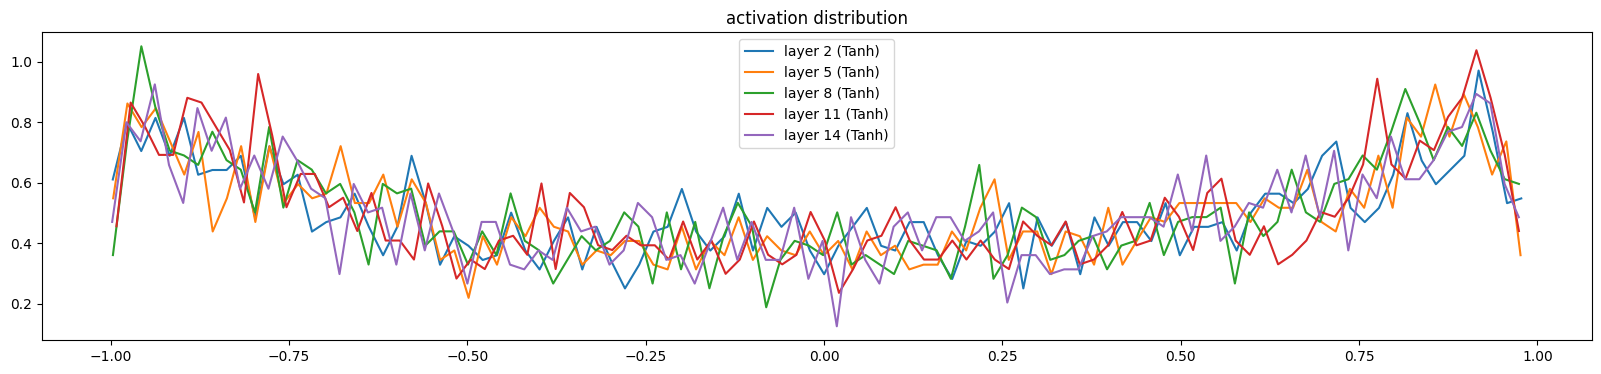

In [7]:
# visualize activation distribution
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.cpu()
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (      Tanh): mean -0.000000, std 1.620135e-03
layer 5 (      Tanh): mean -0.000000, std 1.479692e-03
layer 8 (      Tanh): mean -0.000000, std 1.275823e-03
layer 11 (      Tanh): mean +0.000000, std 1.193016e-03
layer 14 (      Tanh): mean +0.000000, std 1.110317e-03


Text(0.5, 1.0, 'gradient distribution')

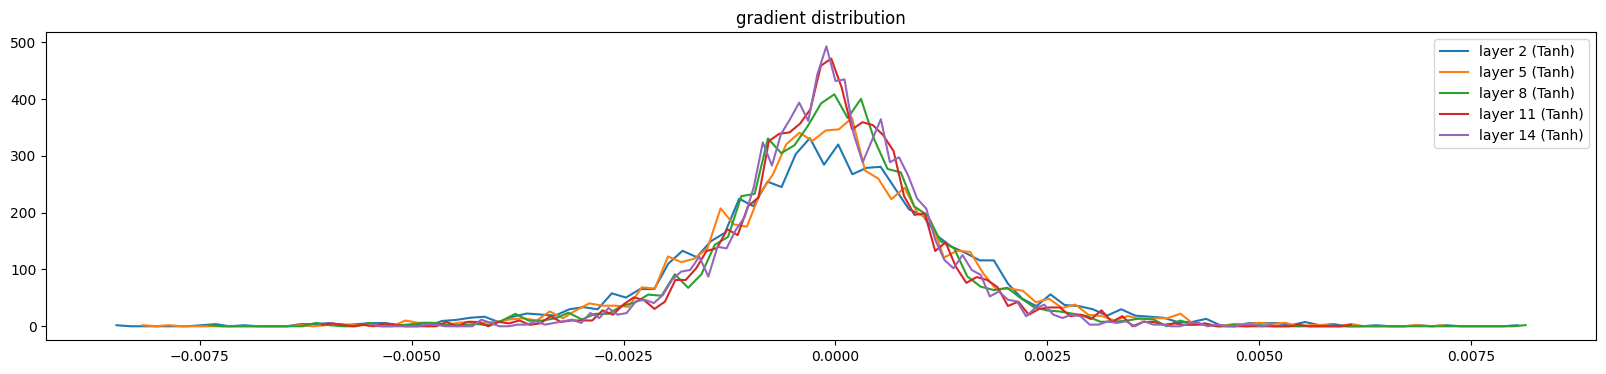

In [8]:
# visualize gradient distribution of activations
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad.cpu()
    print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

weight   (27, 10) | mean +0.000000 | std 3.172727e-03 | grad:data ratio 2.956063e-03
weight  (30, 100) | mean +0.000000 | std 6.543884e-05 | grad:data ratio 3.200614e-06
weight (100, 100) | mean +0.000000 | std 2.997949e-05 | grad:data ratio 1.491352e-06
weight (100, 100) | mean +0.000000 | std 2.849086e-05 | grad:data ratio 1.426219e-06
weight (100, 100) | mean -0.000001 | std 2.543659e-05 | grad:data ratio 1.284709e-06
weight (100, 100) | mean -0.000000 | std 2.492391e-05 | grad:data ratio 1.258086e-06
weight  (100, 27) | mean -0.000001 | std 4.272788e-05 | grad:data ratio 2.155247e-06


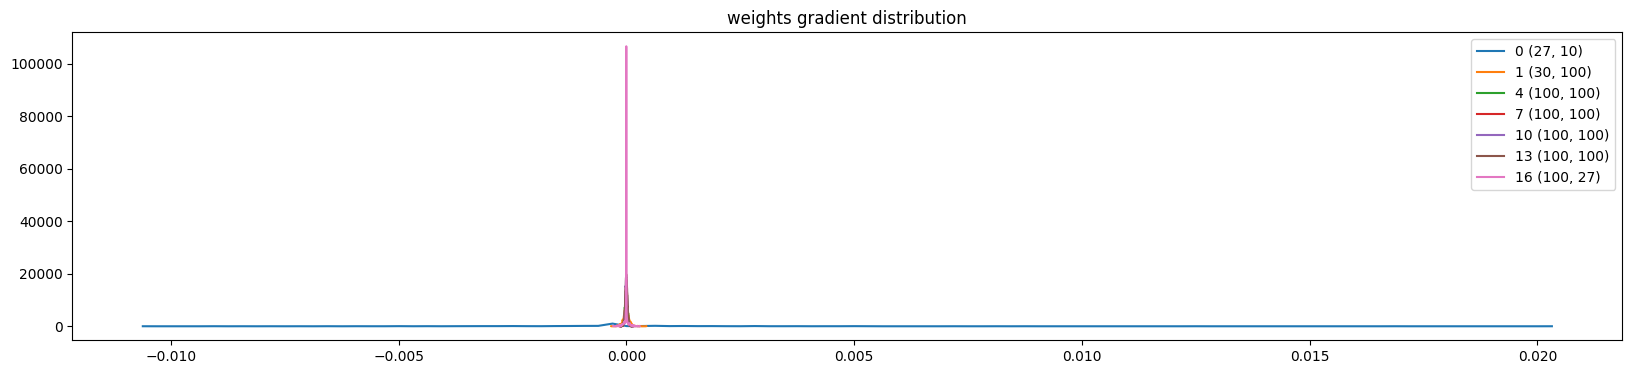

In [9]:
# visualize gradient distribution of linear layer weights
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
  t = p.grad.cpu()
  if p.ndim == 2:
    print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

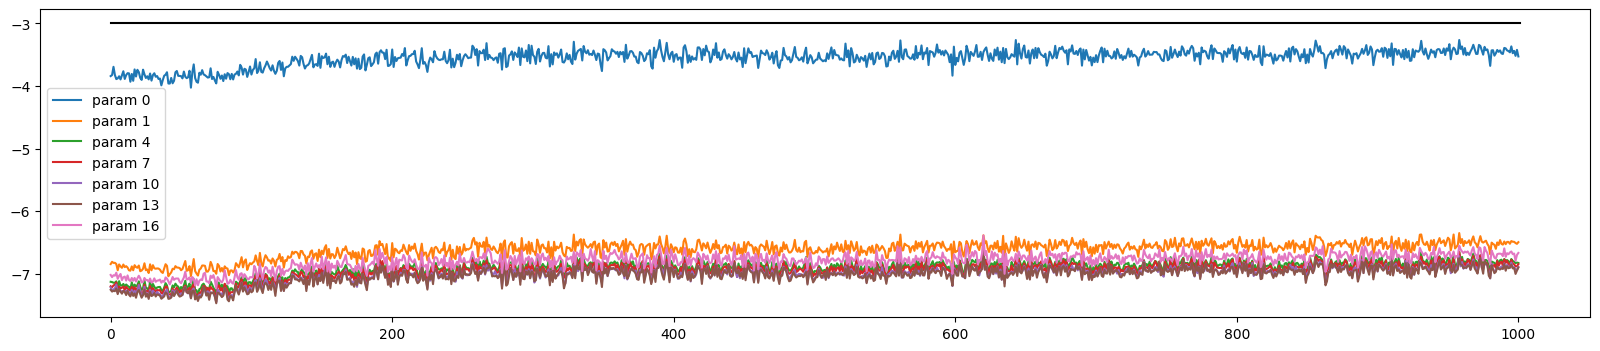

In [10]:
# visualize update step to data ratios over time
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [11]:
# # Extra: sample from the model
# for _ in range(10):
#     out = []
#     context = [0] * block_size # initialize with all ...
#     while True:
#       # forward pass the neural net
#       emb = C[torch.tensor([context])] # (1,block_size,n_embd)
#       x = emb.view(emb.shape[0], -1) # concatenate the vectors
#       for layer in layers:
#         x = layer(x)
#       logits = x
#       probs = F.softmax(logits, dim=1)
#       # sample from the distribution
#       ix = torch.multinomial(probs, num_samples=1, generator=g).item()
#       # shift the context window and track the samples
#       context = context[1:] + [ix]
#       out.append(ix)
#       # if we sample the special '.' token, break
#       if ix == 0:
#         break
#
#     print(''.join(itos[i] for i in out)) # decode and print the generated word